### Vignettes

http://atlas.gs.washington.edu/fly-atac/docs/

### Import packages

In [1]:
library(data.table)
library(dplyr)
library(Matrix)
library(BuenColors)
library(stringr)
library(cowplot)
library(RColorBrewer)
library(ggpubr)
library(irlba)
library(umap)
library(gplots)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: magrittr

Attaching package: ‘ggpubr’

The following object is masked from ‘package:cowplot’:

    get_legend


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



### Preprocess

##### make windows  
`bedtools makewindows -g ../input/hg19/hg19.chrom.sizes -w 5000 > hg19.windows.5kb.bed`

##### Count reads

`bsub < count_reads_windows.sh`  

In [2]:
path = './count_reads_windows_output/'
files <- list.files(path,pattern = "\\.txt$")
length(files)

[1] 5335

In [3]:
#assuming tab separated values with a header    
datalist = lapply(files, function(x)fread(paste0(path,x))$V4) 
#assuming the same header/columns for all files
datafr = do.call("cbind", datalist) 

In [4]:
dim(datafr)

[1] 627478   5335

In [5]:
df_regions = read.csv("./hg19.windows.5kb.bed",
                      sep = '\t',header=FALSE,stringsAsFactors=FALSE)

In [6]:
dim(df_regions)
head(df_regions)

[1] 627478      3

V1,V2,V3
<chr>,<int>,<int>
chr1,0,5000
chr1,5000,10000
chr1,10000,15000
chr1,15000,20000
chr1,20000,25000
chr1,25000,30000


In [7]:
winnames = paste(df_regions$V1,df_regions$V2,df_regions$V3,sep = "_")

In [8]:
head(winnames)

[1] "chr1_0_5000"      "chr1_5000_10000"  "chr1_10000_15000" "chr1_15000_20000"
[5] "chr1_20000_25000" "chr1_25000_30000"

In [9]:
head(sapply(strsplit(files,'\\.'),'[', 2))

[1] "AAACGAAAGCGCAATG-1" "AAACGAAAGGGTATCG-1" "AAACGAAAGTAACATG-1"
[4] "AAACGAAAGTTACACC-1" "AAACGAACAGAGATGC-1" "AAACGAACATGCTATG-1"

In [10]:
colnames(datafr) = sapply(strsplit(files,'\\.'),'[', 2)
rownames(datafr) = winnames

In [11]:
dim(datafr)
head(datafr)

[1] 627478   5335

,AAACGAAAGCGCAATG-1,AAACGAAAGGGTATCG-1,AAACGAAAGTAACATG-1,AAACGAAAGTTACACC-1,AAACGAACAGAGATGC-1,AAACGAACATGCTATG-1,AAACGAAGTGCATCAT-1,AAACGAAGTGGACGAT-1,AAACGAAGTGGCCTCA-1,AAACGAATCAGTGTAC-1,⋯,TTTGGTTGTCAGAAAT-1,TTTGGTTGTTGTATCG-1,TTTGGTTTCAGTGGTT-1,TTTGTGTAGGAAACTT-1,TTTGTGTCAAGCCTTA-1,TTTGTGTCACTCAAGT-1,TTTGTGTCACTGGGCT-1,TTTGTGTGTACGCAAG-1,TTTGTGTGTCTGCGCA-1,TTTGTGTTCAACTTGG-1
chr1_0_5000,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_5000_10000,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_10000_15000,4,0,8,10,0,0,2,4,0,0,⋯,4,6,2,4,0,0,16,6,6,0
chr1_15000_20000,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,2,0,0,0
chr1_20000_25000,0,0,0,0,2,0,2,0,0,0,⋯,0,2,0,0,0,0,0,0,0,0
chr1_25000_30000,0,2,6,4,0,0,2,2,0,2,⋯,0,3,4,10,2,2,4,0,0,0


In [12]:
# saveRDS(datafr, file = './datafr.rds')
# datafr = readRDS('./datafr.rds')

In [13]:
elbow_plot <- function(mat,num_pcs=50,scale=FALSE,center=FALSE,title='',width=3,height=3){
    set.seed(2019) 
    mat = data.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    options(repr.plot.width=width, repr.plot.height=height)
    df_plot = data.frame(PC=1:num_pcs, SD=SVD$d);
#     print(SVD$d[1:num_pcs])
    p <- ggplot(df_plot, aes(x = PC, y = SD)) +
      geom_point(col="#cd5c5c",size = 1) + 
      ggtitle(title)
    return(p)
}

run_umap <- function(fm_mat){
    umap_object = umap(t(fm_mat),random_state = 2019)
    df_umap = umap_object$layout
    return(df_umap)
}


plot_umap <- function(df_umap,labels,title='UMAP',colormap=colormap){
    set.seed(2019) 
    df_umap = data.frame(cbind(df_umap,labels),stringsAsFactors = FALSE)
    colnames(df_umap) = c('umap1','umap2','celltype')
    df_umap$umap1 = as.numeric(df_umap$umap1)
    df_umap$umap2 = as.numeric(df_umap$umap2)
    options(repr.plot.width=4, repr.plot.height=4)
    p <- ggplot(shuf(df_umap), aes(x = umap1, y = umap2, color = celltype)) +
      geom_point(size = 1) + scale_color_manual(values = colormap,breaks=sort(unique(labels))) +
      ggtitle(title)
    return(p)
}

### Identify Clades

In [14]:
metadata <- read.table('../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)
metadata$label = as.character(metadata$label)

In [15]:
binary_mat = as.matrix((datafr > 0) + 0)
binary_mat = Matrix(binary_mat, sparse = TRUE) 

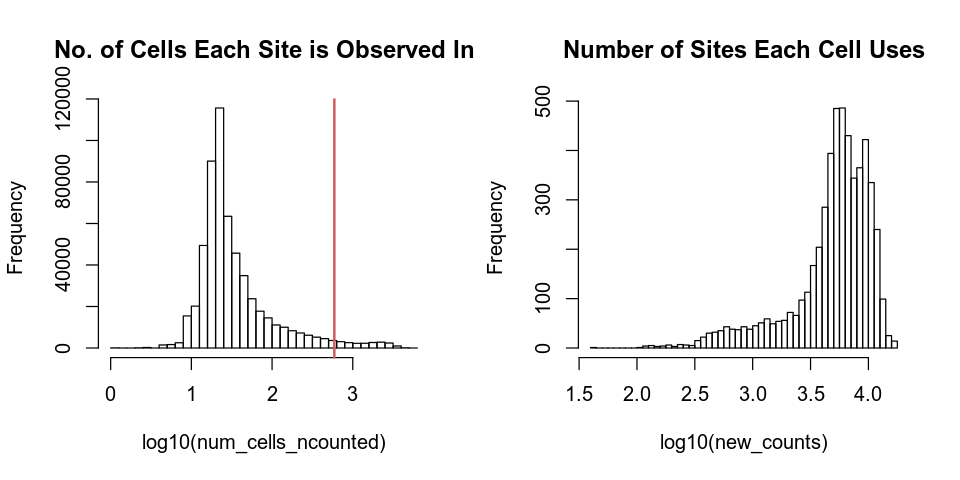

In [16]:
num_cells_ncounted = rowSums(binary_mat)
ncounts = binary_mat[which(num_cells_ncounted >= num_cells_ncounted[order(num_cells_ncounted,decreasing=T)[20000]]),]
new_counts = colSums(ncounts)
# ncounts = ncounts[,new_counts >= quantile(new_counts,probs=0.1)]
ncounts = ncounts[rowSums(ncounts) > 0,]

options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
hist(log10(num_cells_ncounted),main="No. of Cells Each Site is Observed In",breaks=50)
abline(v=log10(num_cells_ncounted[order(num_cells_ncounted,decreasing=T)[20000]]),lwd=2,col="indianred")
hist(log10(new_counts),main="Number of Sites Each Cell Uses",breaks=50)
# abline(v=log10(quantile(new_counts,probs=0.1)),lwd=2,col="indianred")

In [17]:
dim(ncounts)

[1] 20022  5335

In [18]:
nfreqs = t(t(ncounts) / Matrix::colSums(ncounts))
idf = as(log(1 + ncol(ncounts) / Matrix::rowSums(ncounts)), "sparseVector")
tf_idf_counts = as(Diagonal(x=as.vector(idf)), "sparseMatrix") %*% nfreqs

In [19]:
dim(tf_idf_counts)

[1] 20022  5335

In [20]:
p_elbow <- elbow_plot(tf_idf_counts,num_pcs = 200, title = 'PCA')

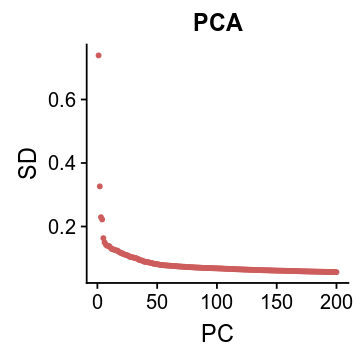

In [21]:
p_elbow

In [22]:
set.seed(2019)
num_pcs = 100
SVD = irlba(tf_idf_counts, num_pcs, num_pcs)
sk_diag = matrix(0, nrow=num_pcs, ncol=num_pcs)
diag(sk_diag) = SVD$d

##remove component 1 as suggested
sk_diag[1,1] = 0

SVDumap_vd = t(sk_diag %*% t(SVD$v))

In [23]:
dim(SVDumap_vd)

[1] 5335  100

In [24]:
LSI_out = t(t(sk_diag %*% t(SVD$v)) %*% t(SVD$u))
LSI_out = t(scale(t(LSI_out)))
LSI_out[LSI_out > 1.5] = 1.5
LSI_out[LSI_out < -1.5] = -1.5

In [25]:
dim(LSI_out)

[1] 20022  5335

In [26]:
#This step can take a minute too
hclust_cells = hclust(proxy::dist(t(sk_diag %*% t(SVD$v)), method="cosine"), method="ward.D2")
hclust_genes = hclust(proxy::dist(t(sk_diag %*% t(SVD$u)), method="cosine"), method="ward.D2")

color_pal = colorRampPalette(brewer.pal(8, "Set2"))(length(unique(metadata$label)))
hmcols = colorpanel(100, "steelblue", "white", "tomato")
cells_tree_cut = cutree(hclust_cells, length(unique(metadata$label)))
lsi_cells = cbind(colnames(ncounts),cells_tree_cut)

#### heatmap 

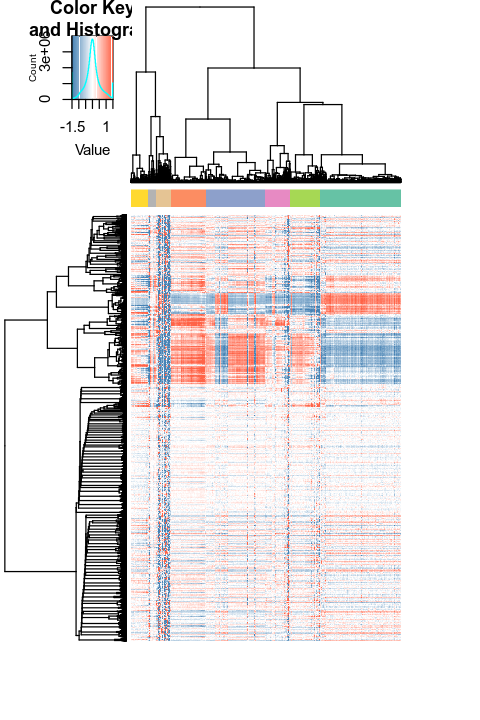

In [27]:
options(repr.plot.width=4, repr.plot.height=6)
heatmap.2(LSI_out, 
          col=hmcols,
          ColSideColors=color_pal[as.factor(cells_tree_cut)],
          #RowSideColors=color_pal[as.factor(genes_tree_cut)],
          Rowv = as.dendrogram(hclust_genes), Colv = as.dendrogram(hclust_cells),
          labRow=FALSE, labCol=FALSE, trace="none",  scale="none",
          useRaster=TRUE)

In [28]:
str(hclust_cells)

List of 7
 $ merge      : int [1:5334, 1:2] -1214 -282 -462 -852 -1561 -1564 -1582 -40 -545 -3961 ...
 $ height     : num [1:5334] 0.00567 0.00607 0.00842 0.00863 0.01059 ...
 $ order      : int [1:5335] 585 578 1451 3201 3421 3253 3835 3338 651 2390 ...
 $ labels     : NULL
 $ method     : chr "ward.D2"
 $ call       : language hclust(d = proxy::dist(t(sk_diag %*% t(SVD$v)), method = "cosine"), method = "ward.D2")
 $ dist.method: chr "cosine"
 - attr(*, "class")= chr "hclust"


In [29]:
dim(SVDumap_vd)

[1] 5335  100

In [30]:
df_umap_LSI <- run_umap(t(SVDumap_vd))
df_umap_LSI = as.data.frame(df_umap_LSI)
row.names(df_umap_LSI) = colnames(datafr)

In [55]:
labels = metadata[colnames(datafr),'label']
num_colors = length(unique(metadata$label))
colormap = colorRampPalette(brewer.pal(8, "Accent"))(num_colors)
names(colormap) = as.character(seq(1,num_colors))

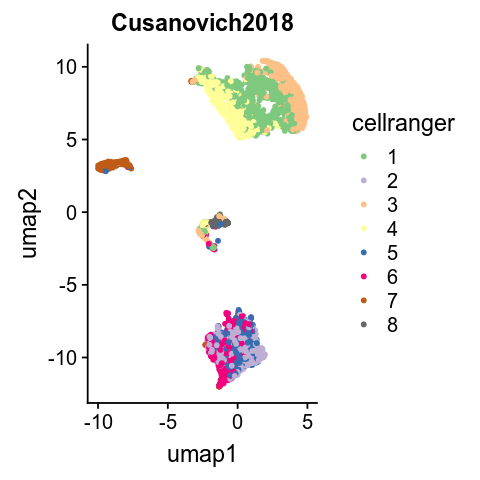

In [56]:
p_LSI <- plot_umap(df_umap_LSI,labels = labels,colormap = colormap,title='Cusanovich2018')
p_LSI = p_LSI +labs(color='cellranger')
p_LSI

In [57]:
labels2 = as.character(cells_tree_cut)
num_colors = length(unique(metadata$label))
colormap2= colorRampPalette(brewer.pal(8, "Set2"))(num_colors)
names(colormap2) = as.character(seq(1,num_colors))

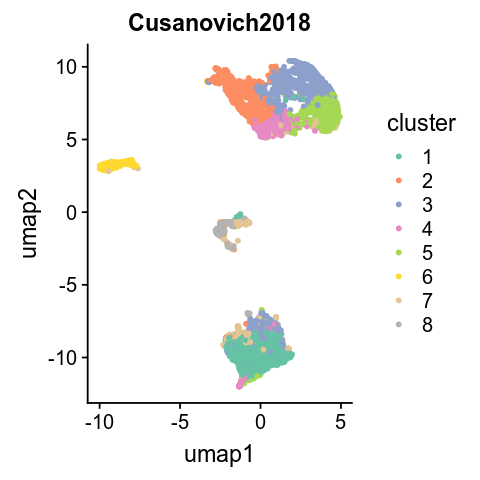

In [58]:
p_LSI_cluster <- plot_umap(df_umap_LSI,labels = labels2,colormap = colormap2,title='Cusanovich2018')
p_LSI_cluster = p_LSI_cluster+labs(color='cluster')
p_LSI_cluster

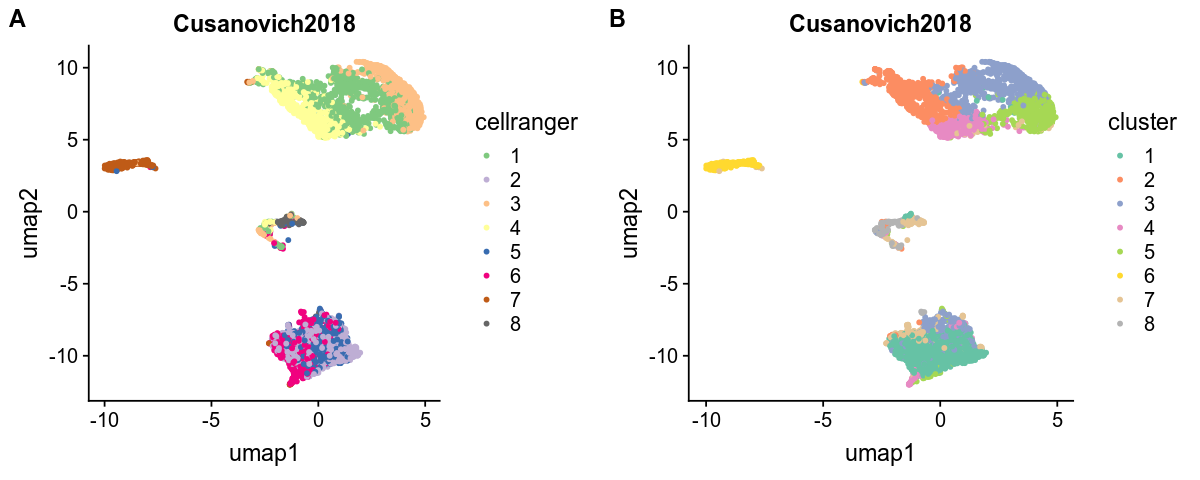

In [62]:
options(repr.plot.width=4*2.5, repr.plot.height=4*1)
p_group = cowplot::plot_grid(p_LSI,p_LSI_cluster,
                   labels = "AUTO",ncol = 2)
p_group

In [63]:
cowplot::ggsave(p_group,filename = 'Cusanovich2018_clades_10xpbmc5k.pdf',width = 4*2.5, height = 4*1)

In [69]:
save.image(file = 'Cusanovich2018_10xpbmc5k_idenfify_clades.RData')

In [64]:
df_pseudobulk = cbind(cellid=colnames(datafr),clusterid=labels2)

In [65]:
head(df_pseudobulk)

cellid,clusterid
AAACGAAAGCGCAATG-1,1
AAACGAAAGGGTATCG-1,1
AAACGAAAGTAACATG-1,2
AAACGAAAGTTACACC-1,2
AAACGAACAGAGATGC-1,1
AAACGAACATGCTATG-1,2


In [68]:
write.table(df_pseudobulk,'./peak_calling/pseudobulk.tsv',quote = FALSE,sep='\t',row.names = FALSE)